**Nota:**

*   Se debe tener encuenta que el google colab debe estar conectado en T4
*   Se descarga la carpeta compartida (Dataset2)
*   Se crea en el propio drive de la persona una carpeta con el mismo nombre (Dataset2)
*   Se pega todo el contenido de la carpeta descargada




# **1. Se importa el Dataset**



*   Se debe iniciar el entorno ejecución del dataset
*   Para montar la unidad de Google Drive en el directorio /content/drive dentro del entorno de trabajo y acceder al dataset compartido en la carpeta "Dataset2".
1.   from google.colab import drive: Esta línea importa la funcionalidad necesaria para interactuar con Google Colab, que es el entorno de trabajo que estamos utilizando.
2.   drive.mount('/content/drive'): Esta línea monta la unidad de Google Drive en el directorio /content/drive dentro de nuestro entorno de trabajo. Ahora podemos acceder a los archivos almacenados en Google Drive como si estuvieramos en nuestro propio computador.


In [ ]:
#Primer paso para correr la red neuronal
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Instalación de tensorflow**


En esta linea instalamos la biblioteca de TensorFlow en el entorno de trabajo que estamos utilizando, el sistema va a descargar e instalar la última versión de TensorFlow, junto con todas las dependencias necesarias. Esto nos permitirá utilizar las funcionalidades y herramientas para nuestro código de red neuronal.
Una vez  instalado, podremos importar y utilizar sus módulos y funciones en nuestro código, permitiendo definir la arquitectura de nuestra red neuronal, entrenarla y evaluarla.

In [ ]:
!pip install tensorflow==2.15.1

# **2. Se importan las Librerias**


*   Se importan una serie de bibliotecas y módulos que serán necesarios. Estas bibliotecas proporcionan funcionalidades para trabajar con archivos, procesar datos, realizar cálculos matemáticos y  crear visualizaciones.
*   Es necesario la ejecución de las librerias para el correcto funcionamiento del proceso.


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
from datetime import datetime
import cv2
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import re
import glob
from tensorflow.keras.callbacks import CSVLogger
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #Para procesar imagenes truncadas
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **3. Generar rutas de archivos con etiquetas**

En estas funciones se preparan los datos de entrada para la red neuronal organizándolos en listas de rutas de archivos y etiquetas, y luego dividiéndolos en conjuntos de entrenamiento, validación y prueba.
* Se recorre el directorio de datos para obtener las rutas de los archivos y las etiquetas de cada imagen.
* Las rutas de los archivos y las etiquetas se devuelven como listas separadas.


In [ ]:
# Generar rutas de archivos con etiquetas
def define_paths(data_dir):
    filepaths = []  # Lista para almacenar las rutas de archivos
    labels = []  # Lista para almacenar las etiquetas de las imágenes

    folds = os.listdir(data_dir)  # Obtener una lista de todas las carpetas en el directorio de datos
    for fold in folds:  # Iterar sobre cada carpeta
        foldpath = os.path.join(data_dir, fold)  # Construir la ruta completa de la carpeta
        filelist = os.listdir(foldpath)  # Obtener una lista de todos los archivos en la carpeta
        for file in filelist:  # Iterar sobre cada archivo
            fpath = os.path.join(foldpath, file)  # Construir la ruta completa del archivo
            filepaths.append(fpath)  # Agregar la ruta del archivo a la lista
            labels.append(fold)  # Agregar la etiqueta de la carpeta a la lista

    return filepaths, labels  # Devolver las listas de rutas de archivos y etiquetas


# Concatenar rutas de archivos con etiquetas en un solo dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')  # Crear una serie de Pandas con las rutas de archivos
    Lseries = pd.Series(classes, name='labels')  # Crear una serie de Pandas con las etiquetas
    return pd.concat([Fseries, Lseries], axis= 1)  # Concatenar las series en un solo dataframe


# Dividir el dataframe en conjuntos de entrenamiento, validación y prueba
def split_data(data_dir):
    # Conjunto de entrenamiento
    files, classes = define_paths(data_dir)  # Obtener las rutas de archivos y etiquetas
    df = define_df(files, classes)  # Crear un dataframe a partir de las rutas y etiquetas
    strat = df['labels']  # Obtener las etiquetas del dataframe
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)  # Dividir el dataframe en conjuntos de entrenamiento y prueba

    # Conjuntos de validación y prueba
    strat = dummy_df['labels']  # Obtener las etiquetas del dataframe
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)  # Dividir el dataframe en conjuntos de validación y prueba

    return train_df, valid_df, test_df  # Devolver los conjuntos de entrenamiento, validación y prueba

# **Preparar los datos de entrenamiento**

Se prepara los datos de entrenamiento, validación y prueba para que puedan ser utilizados por el modelo de red neuronal, se crean generadores de datos de imágenes que convierten las imágenes en tensores y aplican algunas transformaciones, como el volteo horizontal, para aumentar la diversidad de los datos de entrenamiento.
La función "create_gens()" toma los dataframes de entrenamiento, validación y prueba, y los convierte en generadores de datos de imágenes utilizando la biblioteca ImageDataGenerator de Keras. Estos generadores se encargan de cargar y procesar las imágenes a medida que se necesitan durante el entrenamiento y la evaluación del modelo. Además, se define un tamaño de lote personalizado para el conjunto de prueba sea mas eficiente.

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    Esta función toma los dataframes de entrenamiento, validación y prueba, y los adapta a un generador de datos de imágenes, ya que el modelo toma los datos de un generador de datos de imágenes.
    El generador de datos de imágenes convierte las imágenes en tensores.
    '''

    # Definir parámetros del modelo
    img_size = (224, 224)
    channels = 3 # o BGR o escala de grises
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recomendado: utilizar una función personalizada para el tamaño del lote de prueba, de lo contrario podemos utilizar un tamaño de lote normal.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # Esta función se utilizará en el generador de datos de imágenes para la augmentación de datos, simplemente toma la imagen y la devuelve.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Nota: utilizaremos un tamaño de lote de prueba personalizado y haremos shuffle= False
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

# **Visualización de imágenes de entrenamiento**


Esta función, show_images(), permite visualizar una muestra de las imágenes que

*   se utilizarán para entrenar la red neuronal. Esto es útil para verificar que los datos de entrenamiento se han cargado correctamente y tener una idea visual de las clases o categorías que el modelo deberá aprender a distinguir.
*   La función toma un generador de datos de imágenes como entrada, extrae una muestra de imágenes y etiquetas, y las muestra en una cuadrícula de 5x5. Cada imagen se escala al rango de 0 a 255 y se muestra junto con su etiqueta correspondiente. Esta función es valiosa durante el desarrollo y depuración del modelo de red neuronal, ya que permite al usuario inspeccionar visualmente una parte de los datos de entrenamiento y asegurarse de que el modelo tendrá suficiente información para aprender las características relevantes de las imágenes.




In [ ]:
def show_images(gen):
    '''
    Esta función toma el generador de datos y muestra una muestra de las imágenes.
    '''

    # Devuelve las clases y las imágenes a mostrar
    g_dict = gen.class_indices        # Define un diccionario {'clase': índice}
    classes = list(g_dict.keys())   # Define una lista de las claves del diccionario (clases), nombres de clase: cadena
    images, labels = next(gen)        # Obtiene una muestra de tamaño batch del generador

    # Calcula el número de muestras a mostrar
    length = len(labels)        # Longitud de la muestra
    sample = min(length, 25)    # Verifica si la muestra es menor que 25 imágenes

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # Escala los datos al rango (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # Obtiene el índice de la imagen
        class_name = classes[index]   # Obtiene la clase de la imagen
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#  **Entrenamiento Adaptativo**

 Se implementan un enfoque adaptativo y automatizado para el entrenamiento de modelos de redes neuronales, lo que puede mejorar significativamente el rendimiento final del modelo al evitar el estancamiento en mínimos locales.


*   Se  define un callback personalizado llamado MyCallback que monitorea el progreso del entrenamiento, específicamente la precisión de entrenamiento y la pérdida de validación. Cuando la precisión de entrenamiento cae por debajo de un umbral, el callback ajusta la tasa de aprendizaje en función del progreso de la precisión. Si la precisión no mejora después de un cierto número de épocas, la tasa de aprendizaje se reduce por un factor especificado. Este proceso se repite hasta que se alcanza un número máximo de ajustes de la tasa de aprendizaje sin mejora, momento en el cual se detiene el entrenamiento. El callback también guarda las mejores pesas del modelo para asegurar que el modelo final sea el mejor.
*   Tambien se amplía el callback para ajustar la tasa de aprendizaje en función de la pérdida de validación cuando la precisión de entrenamiento supera el umbral. Esto permite un ajuste más fino de la tasa de aprendizaje a medida que el modelo se acerca a su rendimiento óptimo. Además, el callback imprime información detallada sobre el progreso del entrenamiento, lo que permite al usuario monitorear y tomar decisiones informadas durante el proceso.



In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch=None):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience  # especifica cuántos epochs sin mejora antes de ajustar la tasa de aprendizaje
        self.stop_patience = stop_patience  # especifica cuántas veces se ajustará la tasa de aprendizaje sin mejora para detener el entrenamiento
        self.threshold = threshold  # especifica el umbral de precisión de entrenamiento cuando la tasa de aprendizaje se ajustará basada en la pérdida de validación
        self.factor = factor  # factor por el que se reducirá la tasa de aprendizaje
        self.batches = batches  # número de lotes de entrenamiento que se ejecutarán por epoch
        self.epochs = epochs #numero de epochs o epocas por entrenamiento

        # variables de callback
        self.count = 0  # cuenta cuántas veces se ha reducido la tasa de aprendizaje sin mejora
        self.stop_count = 0
        self.best_epoch = 1  # epoch con la pérdida más baja
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # obtiene la tasa de aprendizaje inicial y la guarda
        self.highest_tracc = 0.0  # establece la precisión de entrenamiento más alta en 0 inicialmente
        self.lowest_vloss = np.inf  # establece la pérdida de validación más baja en infinito inicialmente
        self.best_weights = self.model.get_weights()  # establece las mejores pesas como las pesas iniciales del modelo
        self.initial_weights = self.model.get_weights()  # guarda las pesas iniciales si se deben restaurar

    def on_train_begin(self, logs=None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'el tiempo de entrenamiento transcurrido fue {str(hours)} horas, {minutes:4.1f} minutos, {seconds:4.2f} segundos)'
        print(msg)

        # establece las pesas del modelo en las mejores pesas
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        # obtiene la precisión y la pérdida del lote de entrenamiento
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # imprime sobre la misma línea para mostrar el recuento de lotes de entrenamiento en ejecución
        msg = '{0:20s}procesando lote {1:} de {2:5s}-   precisión=  {3:5.3f}   -   pérdida: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))  # obtiene la tasa de aprendizaje actual
        current_lr = lr
        acc = logs.get('accuracy')  # obtiene la precisión de entrenamiento
        v_acc = logs.get('val_accuracy')  # obtiene la precisión de validación
        loss = logs.get('loss')  # obtiene la pérdida de entrenamiento para este epoch
        v_loss = logs.get('val_loss')  # obtiene la pérdida de validación para este epoch

        if acc < self.threshold:  # si la precisión de entrenamiento es menor que el umbral, ajuste la tasa de aprendizaje basada en la precisión de entrenamiento
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc  # define la mejora del progreso del modelo

            if acc > self.highest_tracc:  # la precisión de entrenamiento mejoró en el epoch
                self.highest_tracc = acc  # establece la nueva precisión de entrenamiento más alta
                self.best_weights = self.model.get_weights()  # la precisión de entrenamiento mejoró, así que guarde las pesas
                self.count = 0  # restablece el contador a 0 ya que la precisión de entrenamiento mejoró
                self.stop_count = 0  # restablece el contador de paradas a 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # establece el valor del mejor epoch para este epoch

            else:
                # la precisión de entrenamiento no mejoró, verifique si esto ha sucedido durante el número de epochs de paciencia
                # si es así, ajuste la tasa de aprendizaje
                if self.count >= self.patience - 1:  # se debe ajustar la tasa de aprendizaje
                    lr = lr * self.factor  # ajuste la tasa de aprendizaje por factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # establezca la tasa de aprendizaje en el optimizador
                    self.count = 0  # restablece el contador a 0
                    self.stop_count = self.stop_count + 1  # cuenta el número de ajustes de tasa de aprendizaje consecutivos
                    self.count = 0  # restablece el contador a 0 otra vez
                    if v_loss < self.lowest_vloss:  # Se verifica si la pérdida de validación actual es menor que la pérdida de validación más baja registrada hasta ahora
                        self.lowest_vloss = v_loss  # Si es así, se actualiza el valor de la pérdida de validación más baja con el valor de la pérdida de validación actual
                else:
                    self.count = self.count + 1  # Se incrementa el contador de paciencia.

        else:  # Si la precisión de entrenamiento está por encima del umbral, se ajusta la tasa de aprendizaje en función de la pérdida de validación.
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:  # Se verifica si la pérdida de validación ha mejorado
                self.lowest_vloss = v_loss  #Se reemplaza la pérdida de validación más baja con la nueva pérdida de validación
                self.best_weights = self.model.get_weights()  # Se ajusta la tasa de aprendizaje
                self.count = 0  # restablecer el recuento desde que se mejoró loss validation
                self.stop_count = 0
                self.best_epoch = epoch + 1  # establecer el valor del mejor epoch para este epoch

            else:  # Si la pérdida de validación no ha mejorado
                if self.count >= self.patience - 1:  # Se necesita ajustar la tasa de aprendizaje
                    lr = lr * self.factor  # ajustar la tasa de aprendizaje
                    self.stop_count = self.stop_count + 1  # incrementar el contador de parada porque se ajustó lr
                    self.count = 0  # resetea el contador
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # establece la tasa de aprendizaje en el optimizador
                else:
                    self.count = self.count + 1  # Se incrementa el contador de paciencia

            if acc > self.highest_tracc:
                self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:  # Se verifica si se ha ajustado la tasa de aprendizaje stop_count veces sin mejora
            msg = f'El entrenamiento se ha detenido en el epoch {epoch + 1} después de {self.stop_patience} ajustes de la tasa de aprendizaje sin ninguna mejora.'
            print(msg)
            self.model.stop_training = True  # Se detiene el entrenamiento

# **Visualización del historial de entrenamiento**

La función "plot_training()" toma como entrada la ruta de una carpeta que contiene archivos CSV con los registros de entrenamiento. Luego, recorre cada archivo CSV y extrae los datos relevantes, como la precisión y la pérdida de entrenamiento y validación. Estos datos se utilizan para generar dos gráficos: uno para la precisión y otro para la pérdida.
En cada gráfico, se muestra la evolución de la precisión o la pérdida a lo largo de las épocas, tanto para el conjunto de entrenamiento como para el de validación. Además, se resalta el punto correspondiente a la mejor época, es decir, la época con la menor pérdida de validación y la mayor precisión de validación.
Finalmente, la función guarda los gráficos generados en la misma carpeta que contiene los archivos CSV, lo que permite al usuario revisar fácilmente el progreso del entrenamiento del modelo.

In [ ]:
def plot_training(csv_folder):
    '''
    Esta función toma todos los archivos CSV de una carpeta, traza el historial de precisión y pérdidas,
    y guarda las imágenes generadas en la misma carpeta.
    '''
    # Obtener todos los archivos .csv de la carpeta
    csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

    for csv_file in csv_files:
        # Leer el CSV
        df = pd.read_csv(os.path.join(csv_folder, csv_file))

        # Definir variables necesarias
        tr_acc = df['accuracy'] # Accuracy de entrenamiento
        tr_loss = df['loss'] # Pérdida de entrenamiento
        val_acc = df['val_accuracy'] # Accuracy de validación
        val_loss = df['val_loss'] # Pérdida de validación
        index_loss = np.argmin(val_loss) # Índice de la pérdida de validación más baja
        val_lowest = val_loss[index_loss] # Valor de la pérdida de validación más baja
        index_acc = np.argmax(val_acc) # Índice de la precisión de validación más alta
        acc_highest = val_acc[index_acc] # Valor de la precisión de validación más alta
        Epochs = [i+1 for i in range(len(tr_acc))] # Epochs
        loss_label = f'best epoch= {str(index_loss + 1)}' # Etiqueta para el mejor epoch de pérdida
        acc_label = f'best epoch= {str(index_acc + 1)}' # Etiqueta para el mejor epoch de precisión

        # Graficar historial de entrenamiento
        plt.figure(figsize= (20, 8)) # Tamaño de la figura
        plt.style.use('fivethirtyeight') # Estilo de la gráfica

        plt.subplot(1, 2, 1) # Subgráfico para pérdidas
        plt.plot(Epochs, tr_loss, 'r', label= 'Training loss') # Pérdida de entrenamiento
        plt.plot(Epochs, val_loss, 'g', label= 'Validation loss') # Pérdida de validación
        plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label) # Punto de el mejor epoch de pérdida
        plt.title('Training and Validation Loss') # Título del gráfico de pérdidas
        plt.xlabel('Epochs') # Etiqueta del eje x
        plt.ylabel('Loss') # Etiqueta del eje y
        plt.legend() # Leyenda

        plt.subplot(1, 2, 2) # Subgráfico para precisión
        plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy') # Precisión de entrenamiento
        plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy') # Precisión de validación
        plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label) # Punto de el mejor epoch de precisión
        plt.title('Training and Validation Accuracy') # Título del gráfico de precisión
        plt.xlabel('Epochs') # Etiqueta del eje x
        plt.ylabel('Accuracy') # Etiqueta del eje y
        plt.legend() # Leyenda

        plt.tight_layout() # Ajustar diseño

        # Guardar la imagen en la misma carpeta
        image_file = os.path.join(csv_folder, f"{os.path.splitext(csv_file)[0]}_plot.png")
        plt.savefig(image_file)
        plt.close()

# Ejemplo de uso:
# plot_training('/content/drive/MyDrive/Reportes dataset2 v1/resnet50/0.0001')
        plt.tight_layout # Ajustar diseño
        plt.show() # Mostrar gráficos

# **Visualización del entrenamiento de un modelo ResNet50**


Estas líneas de código ejecutan la función plot_training() que hemos visto anteriormente, pero esta vez con una ruta específica: "/content/drive/MyDrive/Reportes dataset2 v1/resnet50/0.01".
Cuando se ejecuta esta línea, la función plot_training() buscará en la carpeta indicada todos los archivos CSV que contengan los registros de entrenamiento de un modelo ResNet50 con una tasa de aprendizaje de 0.01. Luego, generará dos gráficos que muestran la evolución de la precisión y la pérdida de entrenamiento y validación a lo largo de las épocas.
Estos gráficos serán guardados en la misma carpeta, con el mismo nombre que los archivos CSV, pero con la extensión ".png". Esto permite al usuario revisar fácilmente el progreso del entrenamiento del modelo ResNet50 con una tasa de aprendizaje de 0.01.

In [ ]:
plot_training("/content/drive/MyDrive/Reportes dataset v2/resnet50/0.001")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Reportes dataset v2/resnet50/0.001'

# **Análisis de Estadísticas de Archivos CSV en una Carpeta**

Este programa realiza un análisis detallado de múltiples archivos CSV almacenados en una carpeta específica. Extrae información crucial de cada archivo, como la precisión máxima de validación y la pérdida mínima de validación, junto con las épocas correspondientes en las que se alcanzaron estos valores. Además, organiza estos datos junto con el número de repetición (extraído del nombre del archivo) en un nuevo archivo CSV llamado resumen_resultados.csv. Este archivo resumen facilita la comparación y el análisis de los resultados obtenidos en diferentes ejecuciones, proporcionando una visión clara y organizada del rendimiento de los modelos analizados.


In [ ]:
def calcular_estadisticas(carpeta):
    # Listar todos los archivos en la carpeta
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.csv')]

    resultados = []

    # Expresión regular para extraer el número de repetición del nombre del archivo
    patron_repeticion = re.compile(r'rep_(\d+)')

    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo)

        # Cargar el archivo CSV
        df = pd.read_csv(ruta)

        # Encontrar el val_accuracy más alto y su epoch
        max_val_acc = df['val_accuracy'].max()
        max_val_acc_epoch = df[df['val_accuracy'] == max_val_acc]['epoch'].values[0]

        # Encontrar el val_loss más bajo y su epoch
        min_val_loss = df['val_loss'].min()
        min_val_loss_epoch = df[df['val_loss'] == min_val_loss]['epoch'].values[0]

        # Extraer el número de repetición del nombre del archivo
        match = patron_repeticion.search(archivo)
        if match:
            repeticion = int(match.group(1))
        else:
            repeticion = None

        # Guardar los resultados en una lista
        resultados.append({
            'repeticion': repeticion,
            'max_val_accuracy': max_val_acc,
            'epoch_max_val_accuracy': max_val_acc_epoch,
            'min_val_loss': min_val_loss,
            'epoch_min_val_loss': min_val_loss_epoch
        })

    print(resultados)
    # Crear un DataFrame con los resultados
    results_df = pd.DataFrame(resultados)

    # Guardar los resultados en un nuevo archivo CSV
    results_df.to_csv(f'{carpeta}/resumen_resultados.csv', index=False)

    print(f"Resumen guardado en {carpeta}/resumen_resultados.csv")

# **Cálculo de estadísticas de entrenamiento**
Estas líneas de código ejecutan la función calcular_estadisticas() con la ruta '/content/drive/MyDrive/Reportes dataset2 v1/resnet50/{learning rate}' como argumento. Esta función se encarga de analizar los archivos de registro de entrenamiento (logs) almacenados en la carpeta especificada y calcular estadísticas relevantes.
Al ejecutar esta función, se procesarán todos los archivos de registro de entrenamiento (con extensión .csv) que se encuentren en la carpeta '/content/drive/MyDrive/Reportes dataset2 v1/resnet50/{learning rate}'. Para cada archivo, se extraerán métricas como la precisión y la pérdida de entrenamiento y validación, y se calcularán estadísticas como la mejor época (con menor pérdida de validación), la precisión y pérdida promedio, y la precisión y pérdida máximas.

In [ ]:
carpeta = '/content/drive/MyDrive/Reportes dataset v2/resnet50/0.001'
calcular_estadisticas(carpeta)

[{'repeticion': 1, 'max_val_accuracy': 0.9541062712669371, 'epoch_max_val_accuracy': 23, 'min_val_loss': 0.2899044752120971, 'epoch_min_val_loss': 29}, {'repeticion': 2, 'max_val_accuracy': 0.9516907930374146, 'epoch_max_val_accuracy': 21, 'min_val_loss': 0.3373157680034637, 'epoch_min_val_loss': 21}, {'repeticion': 3, 'max_val_accuracy': 0.946859896183014, 'epoch_max_val_accuracy': 15, 'min_val_loss': 0.3696849346160888, 'epoch_min_val_loss': 15}, {'repeticion': 4, 'max_val_accuracy': 0.9492753744125366, 'epoch_max_val_accuracy': 14, 'min_val_loss': 0.3782716393470764, 'epoch_min_val_loss': 14}, {'repeticion': 5, 'max_val_accuracy': 0.9492753744125366, 'epoch_max_val_accuracy': 13, 'min_val_loss': 0.3542591035366058, 'epoch_min_val_loss': 21}]
Resumen guardado en /content/drive/MyDrive/Reportes dataset v2/resnet50/0.001/resumen_resultados.csv


In [ ]:
def calcular_varianza_general(ruta_base):
    resultados = []

    for carpeta_lr in os.listdir(ruta_base):
        ruta_lr = os.path.join(ruta_base, carpeta_lr)

        if os.path.isdir(ruta_lr):
            # Ruta del archivo resumen_resultados.csv
            archivo_resumen = os.path.join(ruta_lr, 'resumen_resultados.csv')

            if os.path.exists(archivo_resumen):
                # Leer el archivo CSV
                df = pd.read_csv(archivo_resumen)

                # Extraer las columnas necesarias: max_val_accuracy y min_val_loss
                val_accuracies = df['max_val_accuracy'].tolist()
                val_losses = df['min_val_loss'].tolist()

                # Calcular la varianza de val_loss y val_accuracy para este learning rate
                if val_losses and val_accuracies:
                    varianza_val_loss = np.var(val_losses)
                    varianza_val_accuracy = np.var(val_accuracies)

                    # Almacenar los resultados de la varianza
                    resultados.append({
                        'learning_rate': float(carpeta_lr),
                        'varianza_val_loss': varianza_val_loss,
                        'varianza_val_accuracy': varianza_val_accuracy
                    })

    # Convertir los resultados a un DataFrame
    results_df = pd.DataFrame(resultados)

    # Guardar los resultados en un archivo CSV
    results_df.to_csv(f'{ruta_base}/varianza_general.csv', index=False)

    print(f"Varianzas guardadas en {ruta_base}/varianza_general.csv")

In [ ]:
# Especificar la carpeta base donde están las carpetas de los learning rates
ruta_base = "/content/drive/MyDrive/Reportes dataset v2/resnet50"
calcular_varianza_general(ruta_base)

Varianzas guardadas en /content/drive/MyDrive/Reportes dataset v2/resnet50/varianza_general.csv


# **Análisis de Resultados de Experimentos de Aprendizaje Automático**
Este programa está diseñado para analizar y comparar los resultados de varios experimentos de aprendizaje automático almacenados en archivos de texto. Organiza las carpetas por tasas de aprendizaje y extrae las métricas de precisión y pérdida de validación de cada repetición. Luego, identifica la repetición con el mejor rendimiento para cada tasa de aprendizaje y guarda un resumen de estos resultados en un archivo CSV, proporcionando una visión clara y concisa de las mejores configuraciones experimentales.

In [ ]:
def encontrar_mejores_metricas(ruta_base):
    resultados = []

    for carpeta_lr in os.listdir(ruta_base):
        ruta_lr = os.path.join(ruta_base, carpeta_lr)

        if os.path.isdir(ruta_lr):
            mejor_val_acc = 0  # Inicializar mejor_val_acc
            mejor_val_loss = float('inf')  # Inicializar mejor_val_loss
            mejor_repeticion = None  # Inicializar mejor repeticion

            for archivo in os.listdir(ruta_lr):
                if archivo.endswith('.txt'):
                    ruta_archivo = os.path.join(ruta_lr, archivo)
                    repeticion = archivo.split('rep_')[-1].split('.txt')[0]

                    with open(ruta_archivo, 'r') as f:
                        lineas = f.readlines()

                    val_acc = 0
                    val_loss = float('inf')

                    for linea in lineas:
                        if 'Val Accuracy:' in linea:
                            val_acc = float(linea.split('Val Accuracy: ')[1].split()[0])
                        if 'Val Loss:' in linea:
                            val_loss = float(linea.split('Val Loss: ')[1].split()[0])

                    # Comparar y actualizar si encontramos una mejor repetición
                    if val_acc > mejor_val_acc or (val_acc == mejor_val_acc and val_loss < mejor_val_loss):
                        mejor_val_acc = val_acc
                        mejor_val_loss = val_loss
                        mejor_repeticion = int(repeticion)

            # Almacenar los resultados de la mejor repetición para este learning rate
            resultados.append({
                'learning_rate': float(carpeta_lr),
                'repeticion': mejor_repeticion,
                'mejor_val_accuracy': mejor_val_acc,
                'mejor_val_loss': mejor_val_loss
            })

    results_df = pd.DataFrame(resultados)
    # Guardar los resultados en un nuevo archivo CSV
    results_df.to_csv(f'{ruta_base}resumen_general.csv', index=False)

    print(f"Resumen guardado en {ruta_base}resumen_general.csv")

In [ ]:
base_path = '/content/drive/MyDrive/Reportes dataset v2/resnet50/'
encontrar_mejores_metricas(base_path)

Resumen guardado en /content/drive/MyDrive/Reportes dataset v2/resnet50/resumen_general.csv


# **Visualización de la Matriz de Confusión**


Esta función, plot_confusion_matrix(), se encarga de generar una visualización de la matriz de confusión de un modelo de clasificación.
La función toma como entrada la matriz de confusión, las etiquetas de las clases, y algunos parámetros opcionales para personalizar la visualización. Luego, genera una figura que muestra la matriz de confusión en forma de mapa de calor, donde los valores más altos se representan con colores más oscuros. Además, imprime la matriz de confusión y la normaliza si se especifica.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusión', cmap=plt.cm.Blues):
    '''
    Esta función grafica la matriz de confusión utilizando el método de sklearn.
    '''

    plt.figure(figsize=(10, 10)) # Tamaño de la figura
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # Imagen de la matriz de confusión
    plt.title(title) # Título del gráfico
    plt.colorbar() # Barra de color para indicar la correspondencia entre los valores y los colores

    tick_marks = np.arange(len(classes)) # Marcas de los ejes
    plt.xticks(tick_marks, classes, rotation=45) # Etiquetas para el eje x con rotación de 45 grados
    plt.yticks(tick_marks, classes) # Etiquetas para el eje y

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalización de la matriz de confusión
        print('Matriz de Confusión Normalizada') # Mensaje indicando que la matriz está normalizada

    else:
        print('Matriz de Confusión sin Normalizar') # Mensaje indicando que la matriz no está normalizada

    print(cm) # Imprimir la matriz de confusión

    thresh = cm.max() / 2. # Umbral para el texto en las celdas de la matriz
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black') # Añadir el valor de cada celda

    plt.tight_layout() # Ajustar el diseño de la figura
    plt.ylabel('Etiqueta Real') # Etiqueta del eje y
    plt.xlabel('Etiqueta Predicha') # Etiqueta del eje x

# **Preparación de los datos para el entrenamiento**


Primero, se define la ruta del directorio donde se encuentran los datos, que en este caso es "/content/drive/MyDrive/dataset".
Se preparan los datos de entrada para el modelo de red neuronal, dividiendo los archivos en conjuntos de entrenamiento, validación y prueba, y creando generadores de datos de imágenes para una carga y procesamiento eficientes durante el entrenamiento.
se intenta ejecutar dos funciones:


1.   split_data(): Esta función toma el directorio de datos y divide los archivos en tres conjuntos: entrenamiento, validación y prueba. Esto es importante para evaluar el rendimiento del modelo de manera más precisa.
2.   create_gens(): Esta función toma los dataframes de entrenamiento, validación y prueba, y crea generadores de datos de imágenes. Los generadores se encargan de cargar y procesar las imágenes a medida que se necesitan durante el entrenamiento y la evaluación del modelo. También se especifica el tamaño del lote (batch size) para cada conjunto.
3.    Si hay algún problema al ejecutar estas funciones, se imprime el mensaje "Invalid Input" y se detiene la ejecución.




In [ ]:
data_dir="/content/drive/MyDrive/dataset"

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 3311 validated image filenames belonging to 4 classes.
Found 414 validated image filenames belonging to 4 classes.
Found 414 validated image filenames belonging to 4 classes.


# **Visualización de las imágenes de entrenamiento**



Cuando se ejecuta esta línea, la función show_images() toma una muestra de las imágenes y etiquetas del generador de entrenamiento y las muestra en una cuadrícula de 5x4. Visualizando una pequeña parte de los datos de entrenamiento y tener una idea de las características y diversidad de las imágenes que el modelo deberá aprender a procesar.


E, tienen que salir 16 imagenes

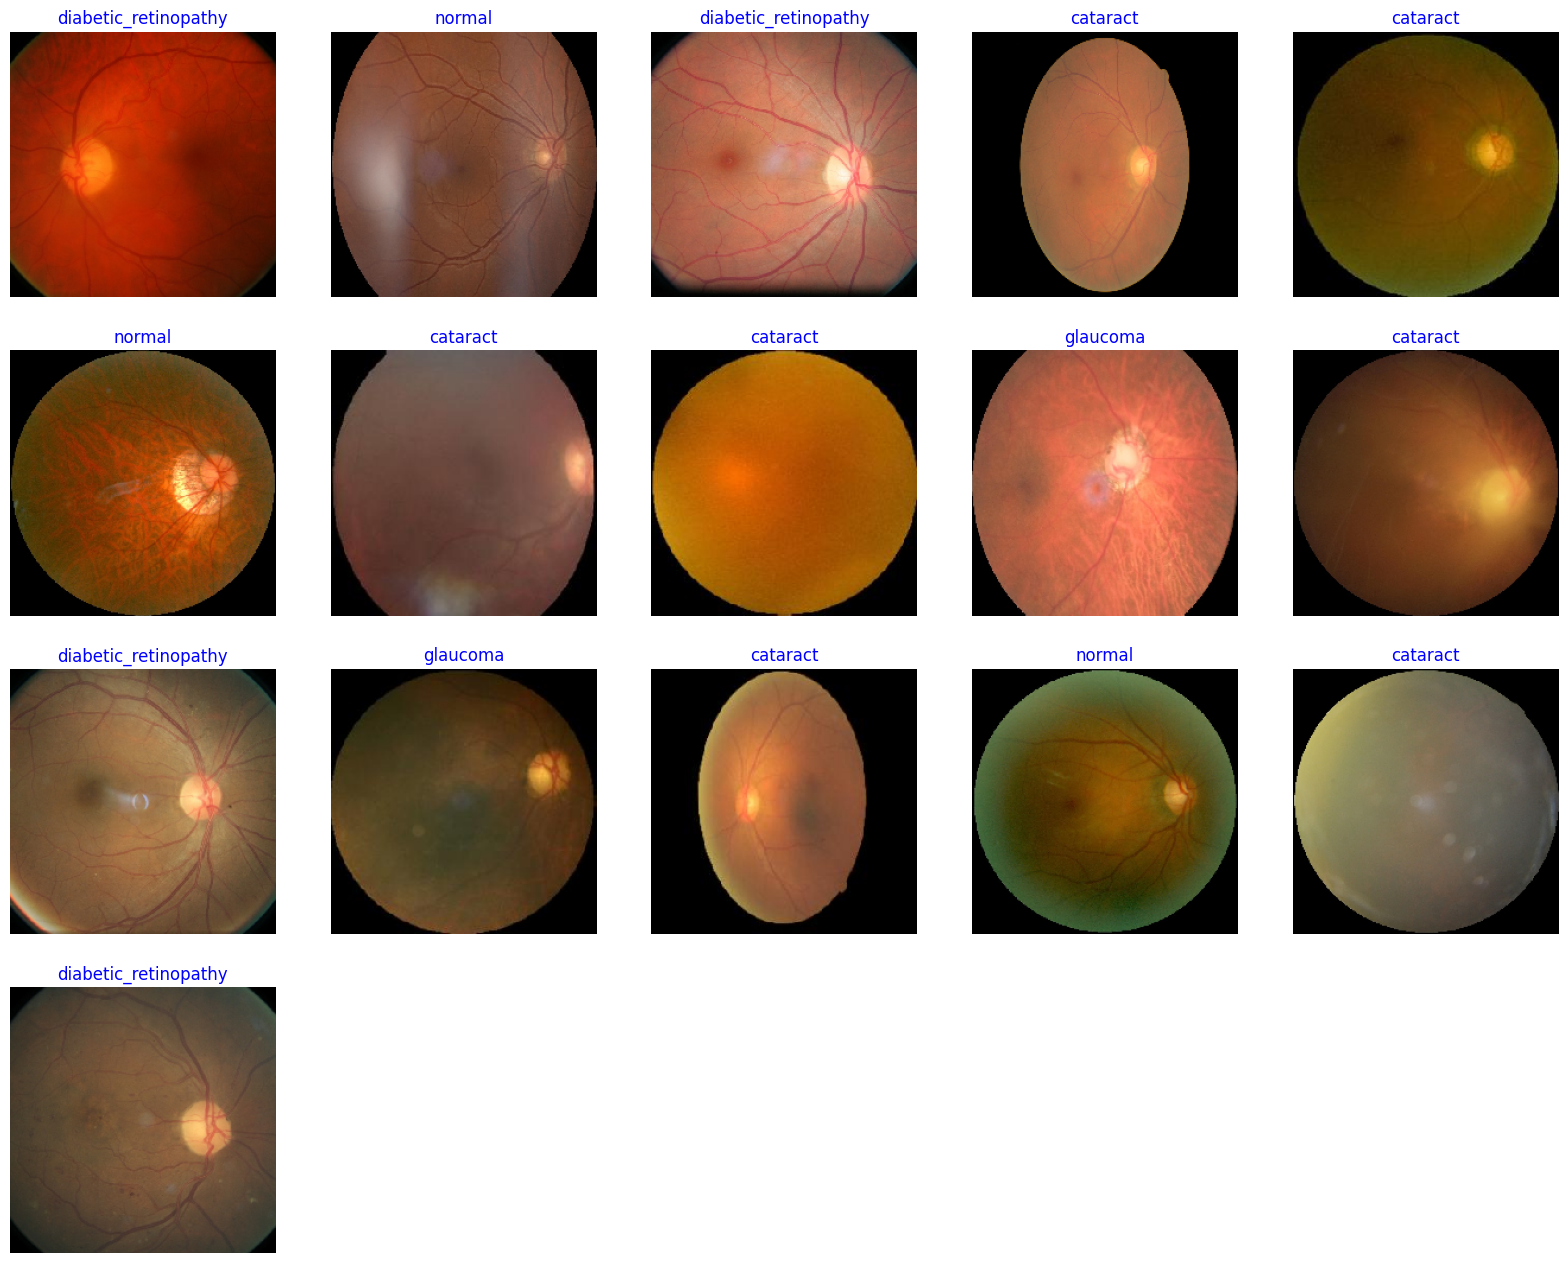

In [ ]:
show_images(train_gen)

# **Entrenamiento y Evaluación de un Modelo ResNet50 con Parámetros Personalizados**

Estas líneas de código definen una función llamada Solve() que entrena y evalúa un modelo de red neuronal basado en la arquitectura ResNet50 con parámetros personalizados. La función toma varios argumentos, como el nombre del modelo, la tasa de aprendizaje, el tamaño del lote, el número de repeticiones, un indicador de si se debe recuperar un modelo existente y el número de épocas de entrenamiento.
Dentro de la función, se generan rutas de archivo y nombres de archivo únicos basados en los parámetros proporcionados. Luego, se crea la estructura del modelo ResNet50 utilizando la biblioteca Keras. Se agrega una capa de normalización por lotes, una capa densa con regularización, una capa de dropout y una capa de salida con activación softmax.
El modelo se compila con la tasa de aprendizaje y el tamaño del lote especificados, y se entrena utilizando el generador de datos de entrenamiento y validación. Se utilizan callbacks, como MyCallback y ModelCheckpoint, para ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento y guardar los mejores pesos del modelo.
Después del entrenamiento, el modelo se guarda en un archivo HDF5 (.h5) y se evalúa en los conjuntos de validación y prueba. Los resultados de la evaluación, como la precisión y la pérdida, se imprimen y se escriben en un archivo de texto.
Finalmente, se genera un gráfico que muestra la precisión de entrenamiento y validación a lo largo de las épocas.
Este código permite entrenar y evaluar un modelo ResNet50 con parámetros personalizados, lo que puede ser útil para explorar diferentes configuraciones y encontrar la que mejor se adapte a un conjunto de datos específico.

In [ ]:
def Solve(nombre, learning, batch, rep, recuperar, epocas):
  full_name = nombre + "_learn_" + str(np.abs(np.log10(learning))) + "_batch_" + str(batch) + "_rep_" + str(rep)
  dest_folder = f"/content/drive/MyDrive/Reportes dataset v2/resnet50/{learning}/"
  temp_folder = f"/content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/{learning}/"
  file_name = dest_folder + full_name + ".txt"
  with open(file_name, 'a') as fid:
    fid.write("")
  # nombre del modelo h5
  file_model = dest_folder + full_name + ".h5"
  now = datetime.datetime.now()
  print(now.strftime("%d/%m/%Y %H:%M:%S"))
  print("Learning rate: " + str(learning) + "    batch size: " + str(batch) + "    rep: " + str(rep))
  print("\n")
  # logger
  nombre_logger = dest_folder + full_name + "_log.csv"
  csv_logger = CSVLogger(nombre_logger, append=True)

  # guardar los mejores pesos en cada epoch
  checkpoint_path = temp_folder + "temp_" + full_name + ".h5"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                           verbose=1,
                                                           monitor='val_loss',
                                                           save_weights_only=True,
                                                           save_freq='epoch',
                                                           save_best_only=True)
  # Crear estructura del modelo
  img_size = (224, 224) # Tamaño de la imagen
  channels = 3 # Canales de la imagen (RGB)
  img_shape = (img_size[0], img_size[1], channels) # Forma de la imagen
  class_count = len(list(train_gen.class_indices.keys())) # Conteo de clases en la capa densa
  from tensorflow.keras.applications import ResNet50

  base_model = tf.keras.applications.resnet50.ResNet50(
  include_top=False,
  weights='imagenet',
  input_shape=img_shape,
  pooling='max',
  classifier_activation='softmax')
  # Crear un nuevo modelo con el learning rate actual
  model = Sequential([
            base_model,
            BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
            Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
                  bias_regularizer=regularizers.l1(0.006), activation='relu'),
            Dropout(rate=0.45, seed=123),
            Dense(class_count, activation='softmax')
  ])

  # Compilar el modelo con el learning rate actual y el batch size definido
  model.compile(Adamax(learning_rate=learning), loss='categorical_crossentropy', metrics=['accuracy'])
  patience = 5 # número de epochs  para esperar para ajustar lr si el valor monitoreado no mejora
  stop_patience = 10 # número de epochs para esperar antes de detener el entrenamiento si el valor monitoreado no mejora
  threshold = 0.95 # si la precisión del entrenamiento es < threshold, ajustar la precisión del monitor; de lo contrario, monitorear la pérdida de validación
  factor = 0.5 # factor para reducir lr
    # se carga el mejor modelo que exista en archivo, si se pide modo recuperacion
  if recuperar == 1:
    try:
      model.load_weights(checkpoint_path)
    except:
      print("No existe el archivo temporal " + checkpoint_path)
      print("Se cancela la ejecución")
      return

  # modo entrenamiento, se debe eliminar cualquier temporal
  if recuperar == 0:
    if os.path.isfile(checkpoint_path):
      os.remove(checkpoint_path)
    else:
      print("No existe previamente el archivo temporal " + checkpoint_path)
  callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                    factor=factor, batches=batch, epochs=epocas), csv_logger, checkpoint_callback]
  history = model.fit(x=train_gen, epochs=epocas, verbose=0, callbacks=callbacks,
                            validation_data=valid_gen, validation_steps=None, shuffle=False)
  # guardar el modelo
  model.save(file_model)
  print("Modelo "+ full_name + " guardado con exito")
  print("\n")

  print("Testeando el modelo...")
  print("\n")
  test_lost, test_acc= model.evaluate(test_gen)
  print("\n")

  print("Validating...")
  print("\n")
  val_lost, val_acc= model.evaluate(valid_gen)
  print("\n")
  # escribir archivo de control
  now = datetime.datetime.now()
  dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
  with open(file_name, 'a') as fid:
    fid.write(dt_string + "\n")
    fid.write("Learning rate: " + str(learning) + "    batch size: " + str(batch) + "    rep: " + str(rep) + "\n")
    fid.write("Test Accuracy: " +  str(round(test_acc,3)) + "    Test Loss: " + str(round(test_lost,4)) + "    Val Accuracy: " + str(round(val_acc,3)) + "    Val Loss: " + str(round(val_lost,4)) + "\n")
    fid.write("\n")

  print("\n")
  print("Test Accuracy:\t", test_acc)
  print("Test Loss:    \t", test_lost)
  print("Val Accuracy: \t", val_acc)
  print("Val Loss:     \t", val_lost)
  print("\n")

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('Epoch')
  plt.legend(["Test accuracy","Val accuracy"], loc ="lower right")
  plt.grid()
  plt.show()

  now = datetime.datetime.now()
  print(now.strftime("%d/%m/%Y %H:%M:%S"))
  print("\n")
  print("==================================================================")
  print("\n")
  print("\n")

29/07/2024 17:15:40
Learning rate: 0.001    batch size: 16    rep: 1


94765736/94765736 [==============================] - 1s 0us/step
No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_1.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /60     7.324   77.892   6.17525  84.058   0.00100  0.00100  accuracy     0.00   1008.96 

Epoch 1: val_loss improved from inf to 6.17525, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_1.h5
 2 /60     4.906   88.644   4.24663  86.715   0.00100  0.00100  accuracy    13.80    46.94  

Epoch 2: val_loss improved from 6.17525 to 4.24663, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_1.h5
 3 /60     3.513   90.094   2.95445  88.164   0.00100

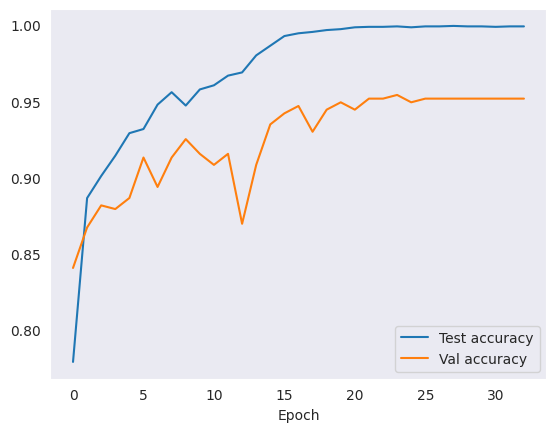

29/07/2024 18:09:20








In [ ]:
Solve(nombre = "resnet_retina_v1_40", learning = 1e-3, batch = 16, rep = 1, recuperar = 0, epocas = 60)

29/07/2024 18:09:37
Learning rate: 0.001    batch size: 16    rep: 2


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_2.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /60     7.243   76.110   6.53428  76.329   0.00100  0.00100  accuracy     0.00    74.66  

Epoch 1: val_loss improved from inf to 6.53428, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_2.h5
 2 /60     4.846   86.530   4.09279  87.440   0.00100  0.00100  accuracy    13.69    46.38  

Epoch 2: val_loss improved from 6.53428 to 4.09279, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_2.h5
 3 /60     3.397   89.369   2.94185  87.681   0.00100  0.00100  accuracy     3.28    47.56  

Epoch 3: val_loss improv

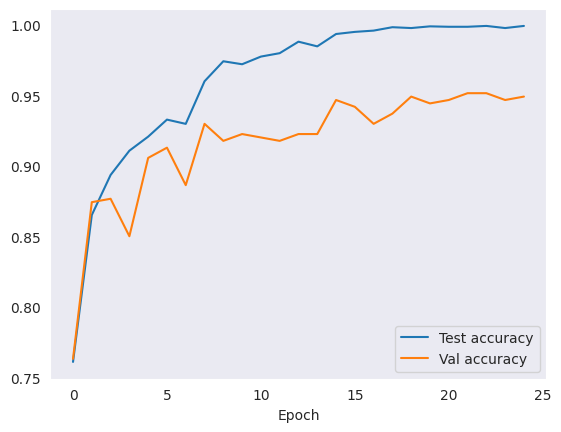

29/07/2024 18:35:02








In [ ]:
Solve(nombre = "resnet_retina_v1_40", learning = 1e-3, batch = 16, rep = 2, recuperar = 0, epocas = 60)

31/07/2024 02:04:16
Learning rate: 0.001    batch size: 16    rep: 3


94765736/94765736 [==============================] - 0s 0us/step
No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_3.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /60     7.265   77.529   6.14008  86.473   0.00100  0.00100  accuracy     0.00   1020.09 

Epoch 1: val_loss improved from inf to 6.14008, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_3.h5
 2 /60     4.852   87.828   4.15662  88.406   0.00100  0.00100  accuracy    13.28    51.19  

Epoch 2: val_loss improved from 6.14008 to 4.15662, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_3.h5
 3 /60     3.399   89.882   2.82140  89.372   0.00100

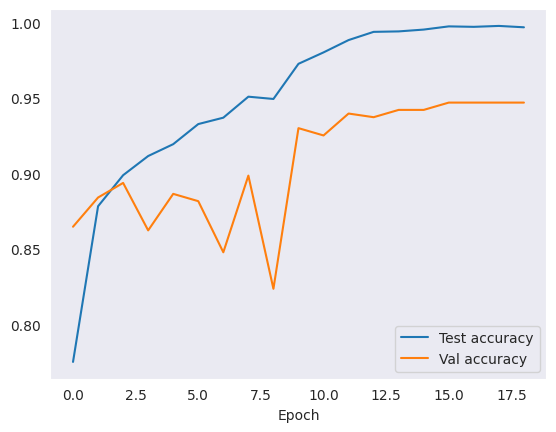

31/07/2024 02:42:32








In [ ]:
Solve(nombre = "resnet_retina_v1_40", learning = 1e-3, batch = 16, rep = 3, recuperar = 0, epocas = 60)

31/07/2024 02:45:28
Learning rate: 0.001    batch size: 16    rep: 4


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_4.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /60     7.377   77.016   7.47132  65.700   0.00100  0.00100  accuracy     0.00    78.34  

Epoch 1: val_loss improved from inf to 7.47132, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_4.h5
 2 /60     4.814   88.704   4.11477  86.473   0.00100  0.00100  accuracy    15.18    51.20  

Epoch 2: val_loss improved from 7.47132 to 4.11477, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_4.h5
 3 /60     3.319   90.849   2.75765  91.546   0.00100  0.00100  accuracy     2.42    49.37  

Epoch 3: val_loss improv

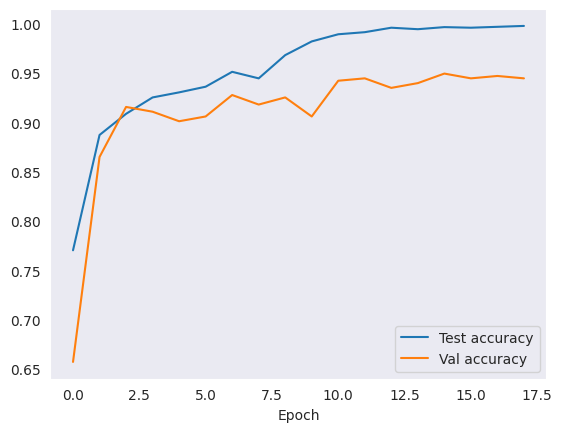

31/07/2024 03:02:16








In [ ]:
Solve(nombre = "resnet_retina_v1_40", learning = 1e-3, batch = 16, rep = 4, recuperar = 0, epocas = 60)

31/07/2024 03:24:35
Learning rate: 0.001    batch size: 16    rep: 5


No existe previamente el archivo temporal /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_5.h5
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /60     7.301   76.321   6.59812  65.700   0.00100  0.00100  accuracy     0.00    77.30  

Epoch 1: val_loss improved from inf to 6.59812, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_5.h5
 2 /60     4.985   86.137   4.33823  87.681   0.00100  0.00100  accuracy    12.86    48.35  

Epoch 2: val_loss improved from 6.59812 to 4.33823, saving model to /content/drive/MyDrive/modelcheckpoints dataset v2/resnet50/0.001/temp_resnet_retina_v1_40_learn_3.0_batch_16_rep_5.h5
 3 /60     3.563   89.097   3.23555  83.816   0.00100  0.00100  accuracy     3.44    48.05  

Epoch 3: val_loss improv

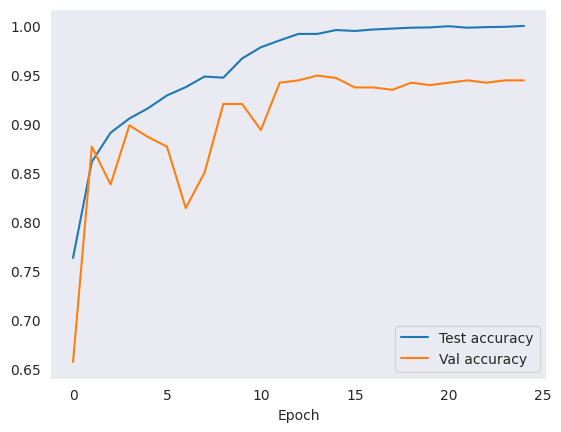

31/07/2024 03:50:10








In [ ]:
Solve(nombre = "resnet_retina_v1_40", learning = 1e-3, batch = 16, rep = 5, recuperar = 0, epocas = 60)

In [ ]:
#cargar modelo
model=tf.keras.models.load_model('/content/drive/MyDrive/Reportes dataset v2/resnet50/0.001/resnet_retina_v1_40_learn_3.0_batch_16_rep_1.h5', compile=False)

In [ ]:
#Obtener predicciones con el modelo ya entrenado
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[2 3 3 2 0 2 2 2 0 2 1 3 2 1 0 1 1 3 2 0 2 2 0 1 1 3 3 0 1 3 3 1 1 1 1 0 2
 3 2 1 1 0 0 3 2 0 1 3 0 2 3 2 0 0 2 3 1 2 1 1 1 3 1 2 3 3 0 1 3 1 2 0 2 3
 0 1 0 1 0 2 0 1 2 3 2 2 2 3 1 0 0 0 3 0 0 1 3 3 2 2 2 2 0 2 0 3 0 2 3 0 3
 0 0 3 2 3 2 2 2 0 1 3 1 1 3 1 1 1 2 0 0 1 1 3 3 0 1 0 3 1 2 2 1 0 1 3 2 2
 2 3 2 2 2 3 3 3 0 0 2 3 0 0 3 3 2 2 2 0 0 2 1 0 1 0 3 0 0 0 3 2 2 0 1 3 3
 0 0 0 2 0 3 1 2 0 3 1 1 1 3 3 3 0 2 2 0 1 0 2 2 2 3 2 0 3 2 3 1 1 2 3 0 3
 1 1 3 1 2 3 1 3 3 3 1 0 2 1 3 2 3 3 3 2 1 0 0 1 2 3 2 1 1 0 1 2 2 1 0 0 1
 3 3 1 2 1 1 0 1 1 0 3 2 1 3 2 3 3 1 1 2 1 0 2 3 3 1 1 2 1 3 3 2 0 3 1 1 1
 2 0 0 0 3 3 3 1 2 1 3 3 1 0 3 1 3 0 0 3 0 3 2 0 1 1 3 0 0 0 1 0 0 1 0 1 2
 2 1 3 1 3 2 1 1 3 1 3 1 1 2 0 3 1 1 1 0 2 1 1 3 2 3 0 3 3 1 3 0 3 0 3 2 1
 3 1 1 3 2 1 1 2 1 3 0 2 2 2 0 3 0 3 2 3 1 2 2 1 2 0 0 1 2 1 3 0 0 3 1 3 1
 2 0 3 0 2 1 0]


Matriz de Confusión sin Normalizar
[[ 90   0   4   2]
 [  0 110   0   0]
 [  4   1  87   9]
 [  3   0   7  97]]
                      precision    recall  f1-score   support

            cataract       0.93      0.94      0.93        96
diabetic_retinopathy       0.99      1.00      1.00       110
            glaucoma       0.89      0.86      0.87       101
              normal       0.90      0.91      0.90       107

            accuracy                           0.93       414
           macro avg       0.93      0.93      0.93       414
        weighted avg       0.93      0.93      0.93       414



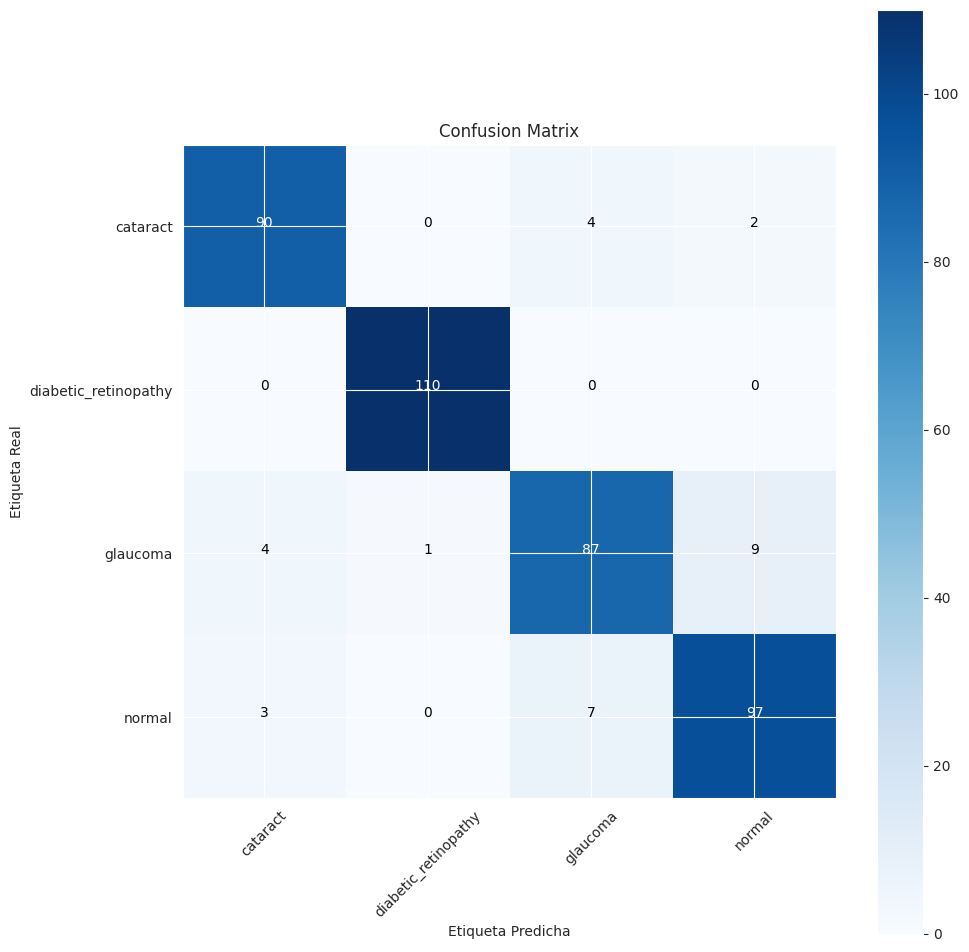

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Matriz de confusion
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Reporte de clasificacion de las diferentes clases
print(classification_report(test_gen.classes, y_pred, target_names= classes))

**1. Introducción**

**Objetivo**

El objetivo de este informe es documentar el proceso y los resultados obtenidos en la clasificación de imágenes de ojos sanos y ojos enfermos utilizando la arquitectura ResNet50. Se busca evaluar la efectividad de tres diferentes learning rates (0.01, 0.001, 0.0001) en la precisión del modelo, con un batch size de 16 y repitiendo cada experimento cinco veces a lo largo de 40 épocas.

**Arquitectura Utilizada**

ResNet50, una variante de la Red Residual (ResNet), es una de las arquitecturas de redes neuronales convolucionales más efectivas y ampliamente utilizadas para tareas de clasificación de imágenes. ResNet50 cuenta con 50 capas profundas y utiliza bloques residuales para superar el problema de la desaparición del gradiente y permitir entrenar redes más profundas sin degradación del rendimiento.

**Dataset Utilizado**

El conjunto de datos utilizado en este estudio es "Clasificación de las enfermedades oculares" (Eyes Disease Classification), compilado por Guna Venkat Doddi y publicado en 2022. Este dataset incluye imágenes de retina normales, retinopatía diabética, cataratas y glaucoma, con aproximadamente 1,000 imágenes diagnósticas por cada clase. Las enfermedades oculares abarcan una variedad de afecciones que afectan la visión y la salud ocular. El objetivo principal de este conjunto de datos es entrenar modelos de aprendizaje profundo para identificar patrones específicos asociados con cada una de estas enfermedades oculares. En esta primera fase del estudio, se decidió clasificar las imágenes en dos categorías (sano y enfermo) en lugar de cuatro (glaucoma, catarata, retinopatía diabética y sano). Esta decisión se tomó para simplificar el problema inicial y evaluar la capacidad del modelo para distinguir entre ojos sanos y cualquier patología ocular, lo que sienta las bases para estudios posteriores más detallados que aborden la clasificación específica de cada enfermedad.

**2. Metodología**

**Preprocesamiento de las Imágenes**

Las imágenes de retinoscopía utilizadas en este estudio se caracterizan por estar en formato .jpg o .jpeg; las imágenes de retinas normales, cataratas y glaucoma están en formato .jpg, mientras que las de retinopatía diabética están en formato .jpeg. Aunque el tamaño de estas imágenes no es relevante debido a la flexibilidad de las redes neuronales convolucionales, se realizaron los siguientes pasos de preprocesamiento para asegurar la calidad de los datos:

*  Redimensionamiento: Las imágenes fueron redimensionadas a 224x224 píxeles para cumplir con los requisitos de entrada de la arquitectura ResNet50.
*  Normalización: Las imágenes fueron normalizadas para tener valores de píxeles entre 0 y 1, lo que ayuda a acelerar el entrenamiento y mejorar la convergencia del modelo.
*  Augmentación de Datos: Se aplicaron técnicas de augmentación de datos como rotaciones, traslaciones, y flips horizontales para aumentar la variabilidad del dataset y mejorar la robustez del modelo.

**Hiperparámetros**

Para el desarrollo del modelo, se utilizaron los siguientes hiperparámetros y configuraciones:

*   Learning Rates: Se probaron tres tasas de aprendizaje diferentes: 0.01, 0.001 y 0.0001.
*   Batch Size: El tamaño del lote se fijó en 16 para todas las pruebas.
*   Número de Épocas: Cada modelo se entrenó durante 40 épocas.
*   Repeticiones: Se fijaron 5 repeticiones para cada learning rate.
*   Función de Pérdida: Se utilizó la función de pérdida de entropía cruzada (Cross-Entropy Loss) para la clasificación.
*   Función de Activación: La función de activación en la capa de salida fue Softmax, adecuada para la clasificación multiclase.
*   Optimización: Se utilizó el optimizador Adam, conocido por su eficiencia y adaptación del learning rate durante el entrenamiento.
*   Validación Cruzada: Se implementó un enfoque de validación cruzada para evaluar el desempeño del modelo y reducir el riesgo de sobreajuste

**Metodología de Prototipado Rápido (MPR)**

Se adoptó la Metodología de Prototipado Rápido (MPR) debido a su enfoque iterativo y ágil, que permite adaptar el modelo a medida que surgen nuevas necesidades y se recopilan datos adicionales. Esta metodología fomenta el uso de herramientas visuales para garantizar un desarrollo eficiente y efectivo del artefacto.

Durante el proceso de desarrollo, se integraron diferentes arquitecturas de aprendizaje profundo como VGG19, ResNet50, Xception, EfficientNet e InceptionV3 para el entrenamiento, validación y pruebas. La variación paramétrica de la tasa de aprendizaje (0.01, 0.001, 0.0001) y las métricas de precisión (accuracy) y pérdida de validación (val_loss) se utilizaron para evaluar el rendimiento del modelo.

El proceso de MPR incluye diferentes tipos de ciclos iterativos:

*  Ciclo 1: Evaluar los cinco modelos (VGG19, ResNet50, Xception, EfficientNet, InceptionV3) con un dataset de dos clases (sano y enfermo).
*  Ciclo 2: Evaluar los tres mejores modelos del ciclo anterior con un dataset de cuatro clases (glaucoma, catarata, retinopatía diabética, sano).
*  Ciclo 3: Escoger el mejor modelo basado en los resultados obtenidos en los ciclos anteriores.

Este ejercicio se encuentra en el ciclo 1.


**3. Análisis de Resultados**

**Comparación entre Learning Rates**

***Tabla General: Mejor Repeticion por Learning Rate***

|learning_rate|repeticion|mejor_val_accuracy|mejor_val_loss|
|---|---|---|---|
|0.0001|5|0.959|0.3159|
|0.001|3|0.966|0.2126|
|0.01|1|0.882|0.3625|

***Tabla Learning Rate 0.01***

|repeticion|	max_val_accuracy|	epoch_max_val_accuracy|min_val_loss|	epoch_min_val_loss|
|---|---|---|---|---|
|1|	0.8891566396|	25|	0.3084842563|	26|
|2|	0.9108433723|	23|	0.3081478179|	23|
|3|	0.739759028	|0	|0.5317903161	|6|
|4|	0.739759028	|2	|0.5877810121	|5|
|5|	0.739759028	|0	|0.5555247664	|7|

***Tabla Learning Rate 0.001***

|repeticion|	max_val_accuracy|	epoch_max_val_accuracy|	min_val_loss|	epoch_min_val_loss|
|---|---|---|---|---|
|2|	0.9590361714|	1	|0.2306025922	|6|
|3|	0.9686747193|	15|	0.2126076519|	37|
|4|	0.9638554454|	15|	0.2138639539|	18|
|5|	0.9566265345|	7	|0.2859930694	|18|
|1|	0.9542168379|	5 |	0.4422007501|	11|

***Tabla Learning Rate 0.0001***

|repeticion|	max_val_accuracy|	epoch_max_val_accuracy|	min_val_loss|	epoch_min_val_loss|
|---|---|---|---|---|
|1|	0.9686747193|	31|	0.3505665362|	0|
|4|	0.9710843563|	30|	0.4763013124|	39|
|3|	0.9590361714|	18|	0.3957396448|	39|
|5|	0.9662650824|	24|	0.3159375787|	12|
|2|	0.9686747193|	31|	0.3770021498|	39|


**4. Ajustes y Paciencia del Modelo**

En este estudio, se utilizó una configuración de paciencia (patience). La paciencia se refiere al número de épocas durante las cuales el modelo puede no mejorar antes de que se ajuste la tasa de aprendizaje. Si la precisión de validación no mejora después de un número determinado de épocas, la tasa de aprendizaje se reduce por un factor predeterminado.

El ajuste de la tasa de aprendizaje y la implementación de paciencia ayudaron a prevenir el sobreajuste y a mantener la eficiencia del modelo. En algunos casos, el modelo no alcanzó las 40 épocas completas debido a esta configuración, lo que resultó en la finalización anticipada del entrenamiento cuando no se observó mejora significativa en la precisión de validación o la pérdida de validación. Esta técnica de ajuste dinámico es crucial para encontrar el balance óptimo entre la precisión del modelo y la eficiencia del entrenamiento.

**5. Conclusiones**

***Conclusiones según Tablas Específicas***

* **Learning Rate 0.01**: Este learning rate mostró una variabilidad considerable en los resultados, con una precisión promedio moderada alrededor del 84.06% al 86.28%. Aunque algunos modelos lograron buenas precisiones, la alta variabilidad sugiere una menor estabilidad.

* **Learning Rate 0.001**: Este learning rate fue el más consistente y proporcionó los mejores resultados en términos de precisión y estabilidad. La precisión promedio se mantuvo alrededor del 92.55% con desviaciones estándar bajas, lo que sugiere que este learning rate es el más adecuado para el modelo ResNet50 en este contexto.

* **Learning Rate 0.0001**: Aunque este learning rate también proporcionó buenos resultados de precisión, las pérdidas de validación fueron significativamente mayores, indicando una menor eficiencia en la convergencia del modelo. Sin embargo, la precisión promedio fue competitiva, alrededor del 92.78%.

***Conclusiones según la Tabla General***

* **Learning Rate 0.0001**: La repetición 5 logró una precisión de validación del 95.9% y una pérdida de validación de 0.3159, lo que demuestra el potencial de este learning rate para obtener altos niveles de precisión, aunque con variabilidad en la pérdida.

* **Learning Rate 0.001**: La repetición 3 alcanzó la mejor precisión de validación con un 96.6% y una pérdida de validación de 0.2126, confirmando la consistencia y efectividad de este learning rate para la arquitectura ResNet50.

* **Learning Rate 0.01**: La repetición 1 logró una precisión de validación del 88.2% y una pérdida de validación de 0.3625, lo que indica que, aunque puede lograr buenos resultados, es menos consistente comparado con los otros learning rates.

***Conclusión General***

El learning rate de 0.001 demostró ser el más efectivo para la arquitectura ResNet50 en la clasificación de imágenes de ojos sanos y enfermos. Los resultados sugieren que este valor proporciona un equilibrio adecuado entre la rapidez de convergencia y la estabilidad del modelo, esto logra altas precisiones con baja variabilidad.

**6. Anexos**

Se incluye en está sección el anexo a la carpeta de ResNet50, en dónde se encontrarán las tablas expuestas en este informe, así como información adicional: https://drive.google.com/drive/folders/1-GfKOi-3P0cvf6qad94uZuvaUeq2g9WX?usp=sharing
